In [1]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from brainflow.board_shim import BoardShim, BrainFlowInputParams, LogLevels, BoardIds
from brainflow.data_filter import DataFilter, AggOperations, FilterTypes, WindowOperations, NoiseTypes

from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, train_test_split

from tsai.models.MINIROCKET import MiniRocketClassifier

import torch

In [ ]:
board_id = BoardIds.CROWN_BOARD.value
params = BrainFlowInputParams()
params.mac_address = "C0:EE:40:84:DD:56"
params.serial_number = "58a99b0107e64cd40ea5e6607882cbe2"
params.board_id = board_id
params.timeout = 5
BoardShim.enable_dev_board_logger()
board = BoardShim(board_id, params)
board.prepare_session()

In [ ]:
inputs = []
outputs = []
BoardShim.disable_board_logger()
board.start_stream()
for i in range(1):
    print("Think Nothing")
    time.sleep(1)
    board.get_board_data()
    time.sleep(10)
    nothing = board.get_board_data()[1:9]
    
    print("Think Left")
    time.sleep(1)
    board.get_board_data()
    time.sleep(10)
    left = board.get_board_data()[1:9]

    print("Think Right")
    time.sleep(1)
    board.get_board_data()
    time.sleep(10)
    right = board.get_board_data()[1:9]
    
    inputs.append(nothing)
    inputs.append(left)
    inputs.append(right)
    outputs.append(1)
    outputs.append(0)
    outputs.append(2)
board.stop_stream()

Think Nothing
Think Yes
Think No


In [ ]:
dataset = np.array([inputs, outputs], dtype=object)
np.save("raw_data.npy", dataset)

NameError: name 'outputs' is not defined

In [191]:
dataset = np.load("raw_data_5min.npy", allow_pickle=True)

In [3]:
# def downsample(data, hz):
#     num_downsamples = int(math.log2(256 / hz))
#     for i in range(1, num_downsamples + 1):
#         data += np.roll(data, i, axis=2)
#     data = (data / num_downsamples)[:,:,num_downsamples::num_downsamples]
#     return data

# def downsample(data, hz):
#     # HZ should be a full number
#     length = data.shape[1]
#     excess = length % (256 / hz)
    
#     # Cut off excess data
#     if excess != 0:
#         data = data[:,excess:]
#     length = data.shape[1]
    
#     length = data.shape[1]
#     split = np.split(data, length // hz, axis=1)
#     data = np.array([np.mean(section) for section in split]).flatten()
#     return data

def downsample(data, hz, channels=False):
    if channels:
        original_type = data.dtype
        data = data.astype('float64')
        
        downsampled_data = np.empty((data.shape[0], int(256 / hz)))
        for i, channel in enumerate(data):
            downsampled_data[i] = DataFilter.perform_downsampling(channel, int(256 / hz), AggOperations.MEAN.value)
        
        return downsampled_data.astype(original_type)
    
    original_type = data.dtype
    data = data.astype('float64')
    return DataFilter.perform_downsampling(data, int(256 / hz), AggOperations.MEAN.value).astype(original_type)

def filter_data(data):
    sr = BoardShim.get_sampling_rate(BoardIds.CROWN_BOARD.value)

    DataFilter.perform_bandpass(data, sr, 5.0, 50.0, 4,FilterTypes.BUTTERWORTH.value, 0)
    DataFilter.remove_environmental_noise(data, sr, NoiseTypes.SIXTY.value) # Americas wires run at 60Hz

In [4]:
def format_dataset(dataset):
    inputs = []
    targets = []
    sr = BoardShim.get_sampling_rate(BoardIds.CROWN_BOARD.value)
    for i in range(len(dataset[0])):
        for j in range(len(dataset[0][i])):
            filter_data(dataset[0][i][j])
        
        data = np.array(dataset[0][i])
        data = np.mean(data, axis=0)
        
        delta = downsample(data, 2)
        theta = downsample(data, 5)
        alpha_low = downsample(data, 8)
        alpha_high = downsample(data, 11)
        beta_low = downsample(data, 15)
        beta_high = downsample(data, 24)
        gamma_low = downsample(data, 35)
        gamma_mid = downsample(data, 45)
        gamma_high = downsample(data, 55)
        
        # Add to inputs and outputs
        for j in range(len(delta)):
            # Raw Samples Passed
            rsp = j * 2
            brain_waves = np.array([delta[j], theta[rsp//5], alpha_low[rsp//8], alpha_high[rsp//11], beta_low[rsp//15], beta_high[rsp//24], gamma_low[rsp//35], gamma_mid[rsp//45], gamma_high[rsp//55]]).flatten()
            
            inputs.append(brain_waves)
            targets.append(dataset[1][i])

    targets = np.array(targets)
    inputs = np.array(inputs)
    
    return inputs, targets

In [ ]:
inputs, targets = format_dataset(dataset)
print(inputs.shape)
print(targets.shape)

(518, 9)
(518,)


In [2]:
from bci_dataset import BCIDataset

train_dataset = BCIDataset('data/train')[:]
inputs = train_dataset['inputs'].cpu().numpy()
# inputs = inputs.flatten(1, 2)
# inputs = inputs.mean(axis=1)
targets = train_dataset['targets']
targets = torch.argmax(targets, dim=1).cpu().numpy()

test_dataset = BCIDataset('data/test')[:]
inputs_test = test_dataset['inputs'].cpu().numpy()
# inputs_test = inputs_test.flatten(1, 2)
# inputs_test = inputs_test.mean(axis=1)
targets_test = test_dataset['targets']
targets_test = torch.argmax(targets_test, dim=1).cpu().numpy()

/home/korte/projects/neuro-nav/bci_dataset.py:45: ComplexWarning: Casting complex values to real discards the imaginary part
  inp[k] = DataFilter.perform_fft(channel[: hz // 2], WindowOperations.NO_WINDOW.value)[:hz // 4]


In [4]:
inputs_train, inputs_valid, targets_train, targets_valid = train_test_split(inputs, targets, test_size=0.3, random_state=42)
# inputs_test, targets_test = format_dataset(test_dataset)

param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

model = MiniRocketClassifier()
model = model.fit(inputs_train, targets_train)

# grid_cv = GridSearchCV(model, param_grid, n_jobs=-1).fit(inputs_train, targets_train)
# model = grid_cv

In [5]:
plt.style.use('seaborn-v0_8-white')

Validation Accuracy: 0.47779545783306815
Test Accuracy: 0.2706620510601471


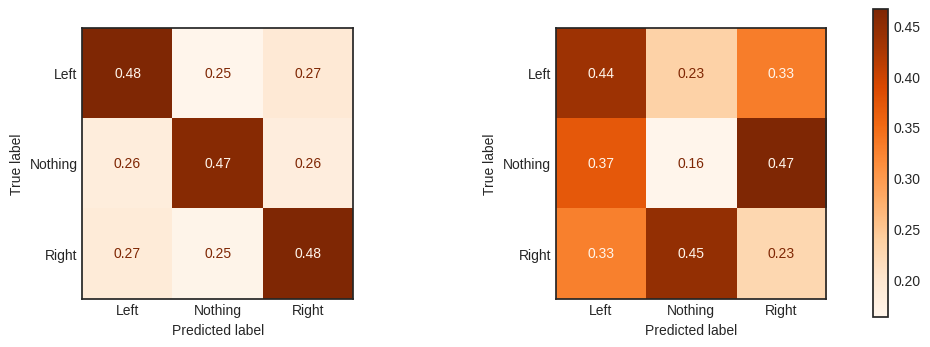

In [11]:
pred_valid = model.predict(inputs_valid)
pred_test = model.predict(inputs_test)

vaccuracy = metrics.accuracy_score(targets_valid, pred_valid)
print(f"Validation Accuracy: {vaccuracy}")

taccuracy = metrics.accuracy_score(targets_test, pred_test)
print(f"Test Accuracy: {taccuracy}")



f, axes = plt.subplots(1, 2)

vcm = metrics.confusion_matrix(targets_valid, pred_valid, normalize='true')
vdisp = metrics.ConfusionMatrixDisplay(confusion_matrix=vcm, display_labels=['Left', 'Nothing', 'Right'])
vdisp.plot(ax=axes[0], cmap=plt.cm.Oranges)
vdisp.im_.colorbar.remove()

plt.subplot(1, 2, 2)
tcm = metrics.confusion_matrix(targets_test, pred_test, normalize='true')
tdisp = metrics.ConfusionMatrixDisplay(confusion_matrix=tcm, display_labels=['Left', 'Nothing', 'Right'])
tdisp.plot(ax=axes[1], cmap=plt.cm.Oranges)
tdisp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.75, hspace=0.1)
f.colorbar(tdisp.im_, ax=axes, shrink=0.5)
fig = plt.gcf()
fig.set_size_inches(12, 8)

plt.show()

In [9]:
model.save('MiniRocketModel')

[Text(0.8108974843869486, 0.9910714285714286, 'X[32] <= 469.762\ngini = 0.666\nsamples = 20818\nvalue = [7202, 7191, 6425]'),
 Text(0.6364469130296299, 0.9732142857142857, 'X[10] <= 1743.884\ngini = 0.666\nsamples = 20239\nvalue = [7039, 6876, 6324]'),
 Text(0.30093700163371534, 0.9553571428571429, 'X[32] <= -461.815\ngini = 0.666\nsamples = 20131\nvalue = [6945, 6866, 6320]'),
 Text(0.015274132995605762, 0.9375, 'X[26] <= -610.374\ngini = 0.602\nsamples = 601\nvalue = [186, 315, 100]'),
 Text(0.006561088364253792, 0.9196428571428571, 'X[32] <= -840.673\ngini = 0.657\nsamples = 161\nvalue = [66, 50, 45]'),
 Text(0.005023633563022675, 0.9017857142857143, 'X[34] <= 936.054\ngini = 0.639\nsamples = 90\nvalue = [29, 41, 20]'),
 Text(0.004777640794825696, 0.8839285714285714, 'X[61] <= 1111.753\ngini = 0.655\nsamples = 81\nvalue = [29, 32, 20]'),
 Text(0.004285655258431739, 0.8660714285714286, 'X[23] <= 83.59\ngini = 0.643\nsamples = 76\nvalue = [28, 32, 16]'),
 Text(0.004039662490234759, 0.

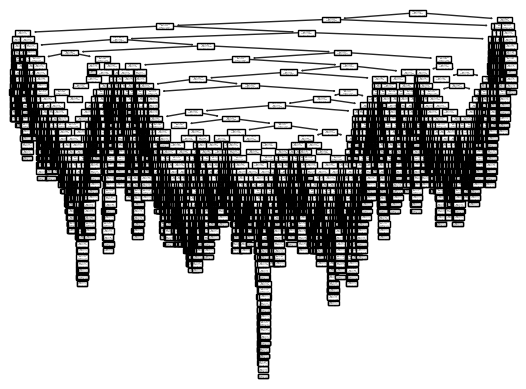

In [31]:
plot_tree(model)

In [ ]:
board.stop_stream()

In [ ]:
board.start_stream()
BoardShim.disable_board_logger()

sample_size = 512
start_time = time.time()
last_read = start_time
time.sleep(3)

realtime_raw_data = board.get_board_data()[1:9]

while start_time + 30 > time.time():
    realtime_raw_data = np.concatenate((realtime_raw_data, board.get_board_data()[1:9]), axis=1)[:,-sample_size:]
    
    realtime_data = np.mean(realtime_raw_data, axis=0)
    
    sr = 256
    
    delta = downsample(realtime_data, 2)[-1]
    theta = downsample(realtime_data, 5)[-1]
    alpha_low = downsample(realtime_data, 8)[-1]
    alpha_high = downsample(realtime_data, 11)[-1]
    beta_low = downsample(realtime_data, 15)[-1]
    beta_high = downsample(realtime_data, 24)[-1]
    gamma_low = downsample(realtime_data, 35)[-1]
    gamma_mid = downsample(realtime_data, 45)[-1]
    gamma_high = downsample(realtime_data, 55)[-1]
    
    
    if time.time() > last_read + 0.5:
        predictions = model.predict(np.array([delta, theta, alpha_low, alpha_high, beta_low, beta_high, gamma_low, gamma_mid, gamma_high]).reshape(1, -1))
        last_read = time.time()
        print(['Left', 'Nothing', 'Right'][predictions[0]])
    
    time.sleep(0.1)

board.stop_stream()

In [ ]:
board.release_session()